# Bechmark: Vern9 vs IRKGL16 (Float128) 

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Initial-value-problem:-Burrau-problem">
             Initial value problem: Burrau problem</a></li>

<li><a href="#Integration-with-Vern9">
             Integration with Vern9</a></li>
             
<li><a href="#Integration-with-IRKGL16-(Adaptive-step)">
             Integration with IRKGL16 (Adaptive-step)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  


## Loading packages

In [1]:
using Pkg
using IRKGaussLegendre,LinearAlgebra,Plots,Statistics
using OrdinaryDiffEq
using BenchmarkTools,DiffEqDevTools

┌ Info: Precompiling IRKGaussLegendre [58bc7355-f626-4c51-96f2-1f8a038f95a2]
└ @ Base loading.jl:1273


In [4]:
BenchmarkTools.DEFAULT_PARAMETERS.samples=10

10

<a href="#top">Back to the top</a>

## Initial value problem: Burrau problem

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [5]:
include("../examples/InitialBurrau.jl")
u0, Gm =InitialBurrau()
N = length(Gm)
(size(u0), typeof(u0),typeof(Gm))

((2, 3, 3), Array{Float64,3}, Array{Int64,1})

Just to check that the output of the function NbodyODE has the expected type:

In [6]:
include("../examples/Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
@show size(du0);

size(du0) = (2, 3, 3)


In [7]:
t0 = 0.
T = 63. # Final time
T= 5.
dt = 10^(-4) # time-step length

tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

In [8]:
setprecision(BigFloat, 106)
u0128, Gm =InitialBurrau(BigFloat)
tspan128=(BigFloat(t0),BigFloat(T))
prob128=ODEProblem(NbodyODE!,u0128,tspan128,Gm);

<a href="#top">Back to the top</a>


## Integration with Vern9

Recommend methods: Non-Stiff Problems

- For high accuracy non-stiff solving ( BigFloat and tolerances like <1e-12 ), JuliaDiffeq recommend
the Vern9 method


In [9]:
sol0 = @time(solve(prob128,Vern9(),saveat=0.1, abstol=1e-24,reltol=1e-24));
test_sol = TestSolution(sol0);

 57.196526 seconds (175.14 M allocations: 7.559 GiB, 6.31% gc time)


In [10]:
sol0.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  94914
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          5932
Number of rejected steps:                          0

## Integration with IRKGL16 (Adaptive-step)


In [25]:
(sol1,iter1,steps1)=@time(solve(prob128,IRKGL162(),
                               reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

  4.043759 seconds (35.41 M allocations: 1.887 GiB, 13.45% gc time)


In [26]:
(sol1.retcode,length(steps1),minimum(steps1[2:end]),mean(iter1),sum(iter1),sol1.destats.nreject,sol1.destats.nf)

(:Success, 87, 0.0001007813650791191366381152598313589226215856132881586382673210112909359649002862, 51.252873563218394, 4459, 5, 36695)

In [28]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  36695
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          86
Number of rejected steps:                          5

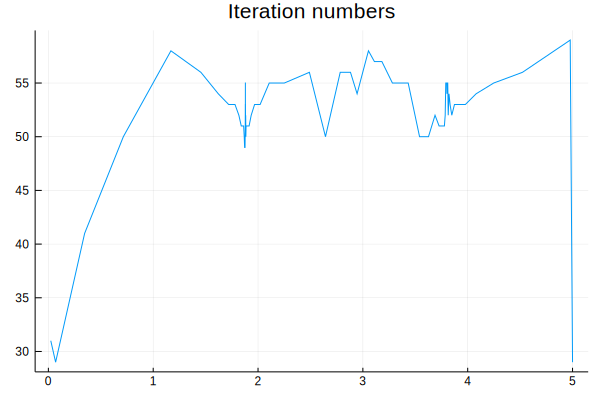

In [29]:
plot(sol1.t[2:end],iter1[2:end], title="Iteration numbers", legend=false)

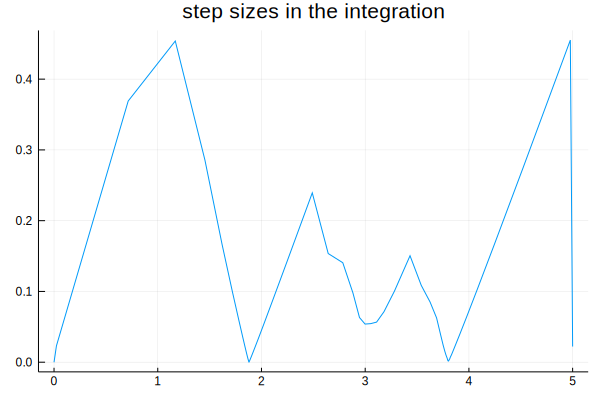

In [30]:
plot(sol1.t,steps1, title="step sizes in the integration", legend=false)

### Plots

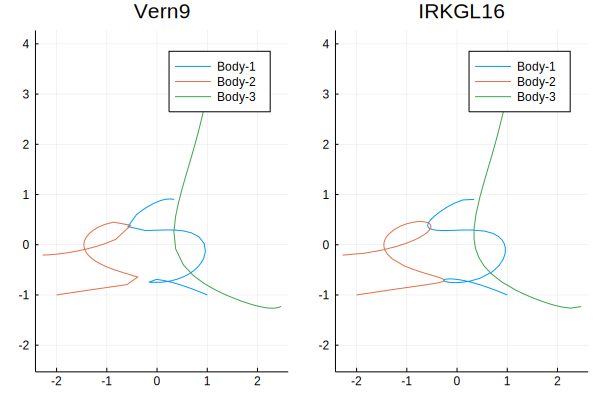

In [31]:
bodylist = ["Body-1", "Body-2", "Body-3"]
ulist0 = sol0.u
tlist0 = sol0.t

pl1 = plot(title="Vern9",aspect_ratio=1)

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl1 = plot!(xlist,ylist, label = bodylist[j])   
end    


pl2 = plot(title="IRKGL16",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl2 = plot!(xlist,ylist, label = bodylist[j])   
end  


#plot(pl)
plot(pl1,pl2,layout=2) 

In [32]:
plot(pl2)
savefig("Burrau.png")

<a href="#top">Back to the top</a>

## Error in energy

In [35]:
setprecision(BigFloat, 256)
u0128, Gm =InitialBurrau(BigFloat)
tspan128=(BigFloat(0.0),BigFloat(T))

(0.0, 5.0)

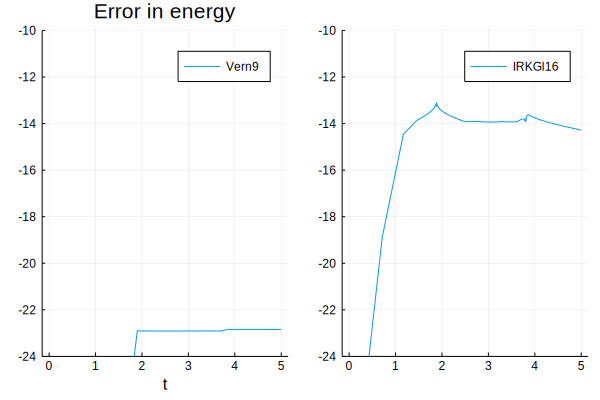

In [36]:
E0=NbodyEnergy(u0128,Gm)
end1=length(steps1)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol0.u[j]),Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),Gm)/E0-1 for j in 1:length(tlist1)]

ylimit1=-24
ylimit2=-10

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
    label="IRKGl16")
plot(p1,p2,layout=2)

In [37]:
(maximum(abs.(EnergyErrors)),maximum(abs.(EnergyErrors1)))

(1.445611948526274623985384149811883707555926576865063955486881349740157008625569e-23, 7.620663331921985503165610555638830690064595841916538949303980043644172831151406e-14)

## Global errror

In [21]:
# IRGL16
apr = appxtrue(sol1,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 22.91785175678873754799741190948826053152862016371848595454368524049493574349179,:L2 => 0.3589796791400135898706265763463661902110109557557133746721210396897479938013169,:final => 1.946609883376611434975617873100924621016823309463147533130253055391436747514594e-14,:l2 => 2.510097457279406383340762498576809089019848909061947069339935641137074284365861,:L∞ => 7.952861211196749080216336497427026268146853232891800862747824992439997592685836)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 22.9179
  :L2    => 0.35898
  :final => 1.94661e-14
  :l2    => 2.5101
  :L∞    => 7.95286

In [22]:
norm(sol1.u[end]-sol0.u[end])

1.260308492963951782463855990807606502327537406600646080326139463633275891596578e-13

## Higher Order Algorithms

In [ ]:
now()

In [23]:
abstols = 1.0 ./ 10.0 .^ (10:20)
reltols = 1.0 ./ 10.0 .^ (10:20);

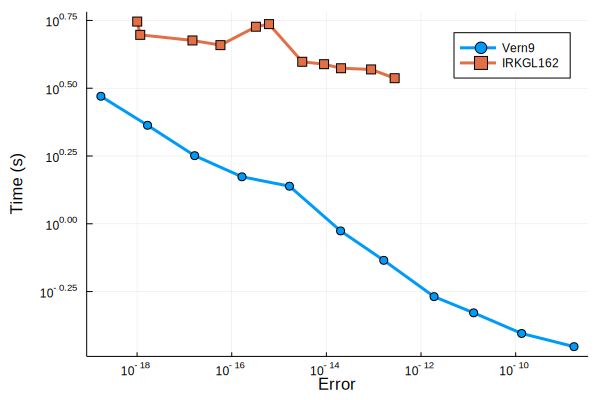

In [24]:
setups = [
#    Dict(:alg=>DP8())
          Dict(:alg=>Vern9())
#          Dict(:alg=>Vern8())   
          Dict(:alg=>IRKGL162())];
wp = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1, maxiters=10000000)
plot(wp)

In [ ]:
now()